In [112]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [113]:
df = pd.read_csv('housing.csv')

In [114]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# 入力変数と教師データに分割

In [115]:
x = df.iloc[:, :-1].values.astype('f')
t = df.iloc[:, -1].values.astype('f')

In [116]:
x.shape

(506, 13)

In [117]:
t.shape

(506,)

In [118]:
len(t)

506

In [119]:
t = t.reshape(len(t), 1)

In [120]:
t.shape

(506, 1)

# データセットの準備

In [121]:
dataset = list(zip(x, t))

# 訓練データと検証データの分割

In [122]:
import chainer
import chainer.functions as F
import chainer.links as L

In [123]:
n_train = int(len(dataset) * 0.7)
n_train

354

In [124]:
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=0)

In [125]:
len(train)

354

In [126]:
len(test)

152

# モデルの定義

# L.Classifierを使う場合

In [127]:
# 13 -> 5 -> 1
class NN(chainer.Chain):
    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(None, n_out)
            
            # Batch Nomalization
            self.bn = L.BatchNormalization(13)
    
    # 順伝播
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [128]:
np.random.seed(0)
# インスタンス化
nn = NN()

In [129]:
# 変更箇所
model = L.Classifier(nn, lossfun=F.mean_squared_error)
model.compute_accuracy = False

# 学習用のモデルを自前で書く場合

In [130]:
# # 13 -> 5 -> 1
# class NN(chainer.Chain):
#     # モデルの構造
#     def __init__(self, n_mid_units=5, n_out=1):
#         super().__init__()
#         with self.init_scope():
#             self.fc1 = L.Linear(None, n_mid_units)
#             self.fc2 = L.Linear(None, n_out)
    
#     # 損失関数の計算
#     def __call__(self, x, t):
#         # 予測値の計算(順伝播)
#         y = self.predictor(x)
#         loss = F.mean_squared_error(t, y)
#         chainer.report({'loss': loss}, self)
#         return loss
    
#     # 順伝播
#     def predictor(self, x):
#         h = self.fc1(x)
#         h = F.relu(h)
#         h = self.fc2(h)
#         return h

In [131]:
# np.random.seed(0)
# model = NN()

# 学習に必要な準備

In [132]:
#optimizer = chainer.optimizers.SGD() # 確率的勾配降下法
optimizer = chainer.optimizers.Adam() # 確率的勾配降下法

optimizer.setup(model)

batchsize = 10

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

from chainer import training
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

from chainer.training import extensions

# エポックの数
epoch = 500

# trainerの宣言
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/housing')

# 検証データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))

trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
# 1 エポックごとにtrainデータに対するloss/accuracyとtestデータに対するloss/accuracy, 経過時間を出力
trainer.extend(extensions.PrintReport(['epoch',
                                       'main/loss',
                                       'validation/main/loss',
                                       'elapsed_time']),
                                       trigger=(1, 'epoch'))

# 学習の実行

In [133]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           575.005     603.083               0.0581083     
2           558.217     591.554               0.11978       
3           548.793     574.242               0.185617      
4           521.226     547.619               0.25029       
5           504.153     507.164               0.314864      
6           462.463     468.416               0.382065      
7           408.87      413.969               0.447033      
8           366.207     357.926               0.514692      
9           293.684     257.43                0.577836      
10          241.922     227.014               0.640543      
11          192.413     178.442               0.70491       
12          154.55      143.469               0.768155      
13          118.269     114.239               0.833148      
14          99.1176     100.104               0.905117      
15          85.8353     81.4782               0.969207      
16          70.8336     71

135         22.3553     17.6617               9.14113       
136         27.6813     16.8084               9.21095       
137         23.5214     16.664                9.28039       
138         25.1738     17.0243               9.35305       
139         29.423      16.4812               9.425         
140         26.817      17.3971               9.49278       
141         27.0338     17.1789               9.56248       
142         24.1305     16.5635               9.63078       
143         26.9474     18.0898               9.7006        
144         29.6502     19.9942               9.76928       
145         21.1949     15.7372               9.84292       
146         25.1804     16.4279               9.91564       
147         20.8907     16.9437               9.9846        
148         24.3835     16.4118               10.0541       
149         22.5814     16.5673               10.123        
150         23.2891     16.7781               10.1915       
151         26.9547     

270         22.9457     13.6819               18.8222       
271         19.064      15.41                 18.9014       
272         21.9487     13.9314               19.0004       
273         19.7314     14.7931               19.0763       
274         22.8678     13.7753               19.1466       
275         19.6238     15.1387               19.2242       
276         20.5049     14.7378               19.3003       
277         25.5927     13.989                19.3727       
278         24.2375     14.1095               19.4443       
279         19.1778     13.7571               19.5165       
280         24.9742     14.3113               19.5879       
281         21.0122     14.4698               19.664        
282         23.3627     14.0901               19.7355       
283         20.6962     15.2378               19.8097       
284         22.3905     14.1784               19.8834       
285         23.7292     13.992                19.9553       
286         21.9902     

405         24.1103     13.5065               29.3209       
406         19.5203     12.947                29.397        
407         26.0601     13.327                29.4707       
408         22.3059     12.8057               29.5465       
409         22.5546     13.5309               29.6249       
410         22.858      13.2229               29.6993       
411         21.7052     13.3218               29.7766       
412         23.5897     13.9167               29.8536       
413         24.8847     14.2854               29.9304       
414         20.2391     14.1087               30.0033       
415         19.897      14.38                 30.0753       
416         21.4814     13.8151               30.1517       
417         23.5663     13.7989               30.229        
418         25.611      14.0511               30.3047       
419         21.9081     15.7638               30.3811       
420         22.4531     13.6645               30.4556       
421         22.8902     

In [134]:
# 結果の確認
import json
with open('result/housing/log') as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)
results.tail()

,main/loss,validation/main/loss,epoch,iteration,elapsed_time
495,26.219648,13.089480,496,17559,36.569114
496,23.044174,13.623693,497,17594,36.649815
497,22.879996,12.362228,498,17630,36.731657
498,21.000424,15.713932,499,17665,36.808608
499,24.678651,13.430211,500,17700,36.888684


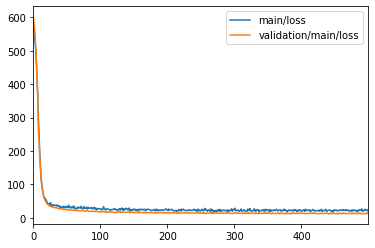

In [135]:
results[['main/loss', 'validation/main/loss']].plot()

In [136]:
loss = results[['validation/main/loss']].values[-1]
loss

array([13.43021065])

In [137]:
import math

In [138]:
math.sqrt(loss)

3.664725180687795

In [139]:
df.head() # ばらつきがある

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
